# Phase 1 -  Data Wrangling 
###  First we need to collect Data.
# For  and explore each dataset, find any "bad formatation" or null value.


In [1]:
import pandas as pd
import os
import plotly.express as px
import matplotlib as plt
import warnings

warnings.filterwarnings("ignore")

# Dublin Bikes

In [ ]:
path = "./"
files = [file for file in os.listdir(path) if file.startswith('dublinbike-historical-data-2023') ] # filtere only historical data files

all_hist = pd.DataFrame()

for file in files:
    current_month = pd.read_csv(path+"/"+file)
    all_hist = pd.concat([all_hist, current_month])
all_hist.head

# Dublin Bikes Revies


In [2]:
import requests
from bs4 import BeautifulSoup 


url_list = ['https://www.tripadvisor.com/Attraction_Review-g186605-d6439815-Reviews-Dublin_Bikes-Dublin_County_Dublin.html',
            'https://www.tripadvisor.com/Attraction_Review-g186605-d6439815-Reviews-or10-Dublin_Bikes-Dublin_County_Dublin.html',
            'https://www.tripadvisor.com/Attraction_Review-g186605-d6439815-Reviews-or20-Dublin_Bikes-Dublin_County_Dublin.html',
            'https://www.tripadvisor.com/Attraction_Review-g186605-d6439815-Reviews-or30-Dublin_Bikes-Dublin_County_Dublin.html',
            'https://www.tripadvisor.com/Attraction_Review-g186605-d6439815-Reviews-or40-Dublin_Bikes-Dublin_County_Dublin.html' ]

headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"}



In [3]:
# Function getinfo retrieves reviews and their corresponding titles and ratings from  tripadvisor URL.
# it uses BeautifulSoup to scrape the website and stores the extracted data in a Pandas DataFrame.
# Args: url (str): The URL of the website containing the reviews to be extracted.
# Returns:  review_df (DataFrame): A Pandas DataFrame containing the title, reviews and ratings.

    
def getinfo(url):     
        
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
   
        review_df = pd.DataFrame()
        
        
        titles = soup.find_all('div', attrs={'class': 'biGQs _P fiohW qWPrE ncFvv fOtGX'})
        title_lst = []
        for title in titles:
             title_lst.append(title.find('span', attrs={'class': 'yCeTE'}).text)
        
        
        reviews = soup.find_all('span', attrs={'class':'JguWG'})

        review_list = []
        for review in reviews:
                review_list.append(review.find('span', attrs={'class': 'yCeTE'}).text)
                
        rate = soup.find_all('svg', attrs={'class':'UctUV d H0'})
        rate_list = []
        for r in rate:
                rate_list.append(r.get('aria-label'))
        
        review_df['title'] = pd.DataFrame(title_lst)
        review_df['review'] = pd.DataFrame(review_list)
        review_df['rate'] = pd.DataFrame(rate_list)
        
        
        return review_df
        
        
        


# this code will call the function "getinfo" for each url in the list "url_list"
# it will wait for 5 seconds between each call to the function "getinfo" ti aviud iverloading the server.

In [8]:
import time
all_reviews_df = pd.DataFrame()
for url in url_list:
    time.sleep(5)
    try:
        all_reviews_df = pd.concat([all_reviews_df, getinfo(url)])    
    except Exception:
        print('Error to scrap url:', url)
        print('Scrapping again!')
        all_reviews_df = pd.concat([all_reviews_df, getinfo(url)])    
    

In [26]:
all_reviews_df['rate'] = all_reviews_df['rate'].str.slice(0,3)


In [28]:

all_reviews_df.reset_index(drop=True, inplace=True)
all_reviews_df.to_csv('all_reviews.csv', index=False)


In [29]:
all_reviews_df = pd.read_csv("all_reviews.csv")

In [30]:
display(all_reviews_df)

,title,review,rate
0,Amazingly brilliant customer service,I'm not the best with computers and had some i...,5.0
1,Still being charged for the bike,Really enjoyed using but tried to return it. I...,1.0
2,Fun way to get around,Visited Dublin over the weekend and thought th...,5.0
3,Great customer experience,Excellent customer service and user experience...,5.0
4,Hhhh,Bad costumer service. They don’t return calls ...,1.0
5,Bad costumer service,Bad costumer service. They don’t return calls ...,1.0
6,"Always rains in Dublin, So cant really use it...",BEWARE!!! Cant believe the Irish Government is...,1.0
7,No Customer Service,"The bikes themselves are a bit clunky, but the...",1.0
8,Scam,The actual use of the bike while in Dublin was...,1.0
9,Useless App,We both tried to register on a few occasions ...,1.0


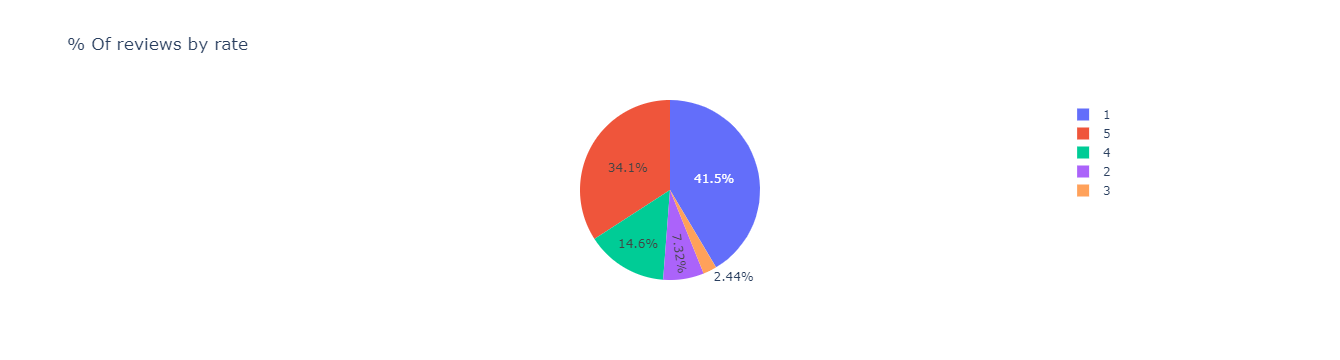

In [44]:
grouped = all_reviews_df.groupby(by = 'rate').count().reset_index()

import plotly.express as px
# This dataframe has 244 lines, but 4 distinct values for `day`

fig = px.pie(grouped, values='review', 
             names='rate',
             title = "% Of reviews by rate"            )
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()

# For  Bicing /stations in Barcelona, the dataset is in json format, 

In [ ]:
import pandas as pd
import json
import requests
url = "https://opendata-ajuntament.barcelona.cat/data/dataset/bd2462df-6e1e-4e37-8205-a4b8e7313b84/resource/e5adca8d-98bf-42c3-9b9c-364ef0a80494/download"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    stations = data['data']
    df = pd.DataFrame(stations['stations'])
    
else:
    print("Error:", response.status_code)
    
df.head(2)


In [ ]:

df.columns

In [ ]:
bicing_df = df[['station_id', 'name', 'address','lat', 'lon','capacity']]
bicing_df.head()

In [ ]:
# Convert nested JSON to DataFrame using json_normalize()
#df = pd.read_json(json_data)
#df = pd.json_normalize(json_data)
# Print the DataFrame
#print(df)

In [ ]:
import requests
import pandas as pd

url = "https://opendata-ajuntament.barcelona.cat/data/dataset/bd2462df-6e1e-4e37-8205-a4b8e7313b84/resource/e5adca8d-98bf-42c3-9b9c-364ef0a80494/download"




In [ ]:
all_hist.info()

In [ ]:
all_hist.info()

In [ ]:
all_hist.isnull().sum()


In [ ]:
#all_hist.reset_index()

In [ ]:
all_hist['STATION ID'].nunique()

In [ ]:
bike_stations = all_hist[['STATION ID','NAME','BIKE_STANDS','STATUS','LATITUDE', 'LONGITUDE']].drop_duplicates(subset=["STATION ID"])
bike_stations.head()

In [ ]:
import plotly.express as px
fig = px.scatter_mapbox(bike_stations, 
                        lat="LATITUDE",
                        lon="LONGITUDE", 
                        color="STATUS", 
                        size="BIKE_STANDS", 
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        size_max=15, 
                        zoom=12, 
                        hover_data=["BIKE_STANDS"],
                        mapbox_style="open-street-map")

# Update layout for larger figure size
fig.update_layout(
    title="Bike Stations in Dublin",
    autosize=False,
    width=1200, 
    height=600,  
)
fig.show()

In [ ]:
fig = px.pie(bike_stations, values='BIKE_STANDS', names='STATUS')
fig.update_layout(
    title="Bike Stations in Dublin",
    autosize=False,
    width=400,  
    height=400, 
)

fig.show()

In [ ]:
bike_usage = all_hist[['TIME', 'STATION ID', 'NAME', 'BIKE_STANDS','AVAILABLE_BIKES']]

bike_usage['TIME'] = pd.to_datetime(bike_usage['TIME'])
bike_usage.set_index('TIME')

In [ ]:
bicing_df['capacity'].sum()

In [45]:
bicing_df.head()

NameError: name 'bicing_df' is not defined

In [ ]:
# pandas and numpy already imported at the begining of this notebook
pop02_df = pd.read_csv(pea04)
pop02_df




    As the second dataset has data from 2011 to 2023. We need to filter the first dataframe, getting data from 1996 to 2010, and after that, we will merge the dataframes into one. We'll call it 'population_df

In [ ]:
# concat needs only one
population_df=pd.concat([pop01_df, pop02_df],ignore_index=True)
population_df

In [ ]:
# Merge the two DataFrames on the 'Year' column
population_df = pop01_df.merge(pop02_df, on='Year', how='outer')
population_df.head()

    Now, we have columns _x and _y. We need to fill the NaN values in the _x columns with values from the corresponding _y columns.

    We will create a loop to check the column names in each item of a list called 'column_names.' If the column name ends with _x, we will fill it with values from the corresponding column ending in _y."

In [ ]:

# Getting the collumns names
column_names = population_df.columns

# for loop to fill the _x columns
for column_name in population_df.columns:
    if column_name.endswith('_x'):
        population_df[column_name].fillna(population_df[column_name[:-2]+'_y'], inplace=True)
    
population_df.head() 

In [ ]:
#function to rename the columns merged,  remove the '_x' at the end.
# function rename_columns  will check into columns list, and each column ended in _x, the _x (-2 letters) will be removed.

def rename_columns_x(df):

  # Create a list of the new column names.
  new_column_names = []
  for column_name in population_df.columns:
    if column_name.endswith('_x'):
      new_column_name = column_name[:-2]
    else:
      new_column_name = column_name

    new_column_names.append(new_column_name)

  # Rename the columns of the DataFrame.
  population_df.columns = new_column_names

  return df


# calling the function to rename the columns of the DataFrame.
population_df = rename_columns_x(population_df)

population_df.columns


In [ ]:
# This for loop will drop every column ended with _y 
for col in population_df.columns:
    if col.endswith("_y"):
        population_df.drop(col, axis=1, inplace=True)

population_df.head()

### Looking for duplicated rows

In [ ]:
population_df[population_df.duplicated()]

In [ ]:
# cjq01  variable already inicialized at the begining of this notebook.
crime_df=pd.read_csv(cjq01)
crime_df.head()

Also We can see the top 5 most comon type of offence

## Crime Rate dataset
Now that we have an overall about the population, lets dive into the crime rate dataframe, using some statistical approach: Lets call it: "crime_df"
        

In [ ]:
from scipy import stats
from empiricaldist import Pmf, Cdf
from matplotlib.ticker import PercentFormatter



## The method describe shows important information about the dataset.
    * mean: The average of crime over these types.
    * max: The largest value in the type of crime.
    * median: (middle value) of recorded crime incidents.
    * minimum: and maximum values in the dataset.
    * standard deviation to measure the spread of the data.


In [ ]:
crime_df['VALUE'].describe()